In [2]:
# Load pyspark
import findspark

findspark.init()

from pyspark import SparkContext

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor

from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler

from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml import Pipeline

from pyspark.sql.window import Window
from pyspark.ml.stat import Correlation

import pandas as pd
import numpy as np

# charting
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

spark = SparkSession.builder.appName("dengue").getOrCreate()

### Chargement des données

In [3]:
path_to_data = "data/"

df_features = spark.read.csv(path_to_data + "dengue_features_train.csv",
                             header=True)
df_labels = spark.read.csv(path_to_data + "dengue_labels_train.csv",
                           header=True)

#join df_features + df_labels
df_train = df_features.join(df_labels, ['city', 'year', 'weekofyear'])

print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))

df_train = (1456, 25)


### Nettoyage des données

In [4]:
# The 2 columns 'precipitation_amt_mm' and 'reanalysis_sat_precip_amt_mm' are the same
# we drop 'precipitation_amt_mm'
df_train = df_train.drop('precipitation_amt_mm')

# recast 'week_start_date' as a date. Nice to have for plotting or time series analysis
df_train = df_train.withColumn('week_start_date', F.to_date('week_start_date', 'yyyy-MM-dd'))

# recast 'year' and 'weekofyear' to integer
df_train = df_train \
    .withColumn('year', df_train['year'].cast('int')) \
    .withColumn('weekofyear', df_train['weekofyear'].cast('int'))

# cast columns to float
for col_name in df_train.columns[4:-1]:
    df_train = df_train.withColumn(col_name, df_train[col_name].cast('float'))

# cast column total_cases as integer
df_train = df_train.withColumn('total_cases', df_train['total_cases'].cast('int'))

df_train.printSchema()

root
 |-- city: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- weekofyear: integer (nullable = true)
 |-- week_start_date: date (nullable = true)
 |-- ndvi_ne: float (nullable = true)
 |-- ndvi_nw: float (nullable = true)
 |-- ndvi_se: float (nullable = true)
 |-- ndvi_sw: float (nullable = true)
 |-- reanalysis_air_temp_k: float (nullable = true)
 |-- reanalysis_avg_temp_k: float (nullable = true)
 |-- reanalysis_dew_point_temp_k: float (nullable = true)
 |-- reanalysis_max_air_temp_k: float (nullable = true)
 |-- reanalysis_min_air_temp_k: float (nullable = true)
 |-- reanalysis_precip_amt_kg_per_m2: float (nullable = true)
 |-- reanalysis_relative_humidity_percent: float (nullable = true)
 |-- reanalysis_sat_precip_amt_mm: float (nullable = true)
 |-- reanalysis_specific_humidity_g_per_kg: float (nullable = true)
 |-- reanalysis_tdtr_k: float (nullable = true)
 |-- station_avg_temp_c: float (nullable = true)
 |-- station_diur_temp_rng_c: float (nullable = true)
 

In [5]:
print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))

# identify null value
# ===================
for col_name in df_train.columns:
    print("{} => {}".format(col_name,
                            df_train.filter(F.isnull(df_train[col_name])).count()))

df_train = (1456, 24)
city => 0
year => 0
weekofyear => 0
week_start_date => 0
ndvi_ne => 194
ndvi_nw => 52
ndvi_se => 22
ndvi_sw => 22
reanalysis_air_temp_k => 10
reanalysis_avg_temp_k => 10
reanalysis_dew_point_temp_k => 10
reanalysis_max_air_temp_k => 10
reanalysis_min_air_temp_k => 10
reanalysis_precip_amt_kg_per_m2 => 10
reanalysis_relative_humidity_percent => 10
reanalysis_sat_precip_amt_mm => 13
reanalysis_specific_humidity_g_per_kg => 10
reanalysis_tdtr_k => 10
station_avg_temp_c => 43
station_diur_temp_rng_c => 43
station_max_temp_c => 20
station_min_temp_c => 14
station_precip_mm => 22
total_cases => 0


In [6]:
# Fill Null value with previous value
w = Window().partitionBy().orderBy(F.col('week_start_date'))

for col_name in df_train.columns[4:-1]:
    df_train = df_train.withColumn(col_name, F.last(col_name, True).over(w))
    
# identify null value
for col_name in df_train.columns:
    print("{} => {}".format(col_name,
                            df_train.filter(F.isnull(df_train[col_name])).count()))

city => 0
year => 0
weekofyear => 0
week_start_date => 0
ndvi_ne => 0
ndvi_nw => 0
ndvi_se => 0
ndvi_sw => 0
reanalysis_air_temp_k => 0
reanalysis_avg_temp_k => 0
reanalysis_dew_point_temp_k => 0
reanalysis_max_air_temp_k => 0
reanalysis_min_air_temp_k => 0
reanalysis_precip_amt_kg_per_m2 => 0
reanalysis_relative_humidity_percent => 0
reanalysis_sat_precip_amt_mm => 0
reanalysis_specific_humidity_g_per_kg => 0
reanalysis_tdtr_k => 0
station_avg_temp_c => 0
station_diur_temp_rng_c => 0
station_max_temp_c => 0
station_min_temp_c => 0
station_precip_mm => 0
total_cases => 0


### Plot

In [7]:
from pyspark.sql.functions import min, max

df_train_sj = df_train.filter(df_train.city == 'sj')
min_date_sj, max_date_sj = df_train_sj.select(min("week_start_date"), max("week_start_date")).first()

print("San Juan data:")
print("df_train_sj = ({}, {})".format(df_train_sj.count(), len(df_train_sj.columns)))
print("\tdate_start = {} / date_stop = {}".format(min_date_sj, max_date_sj))

df_train_iq = df_train.filter(df_train.city == 'iq')
min_date_iq, max_date_iq = df_train_iq.select(min("week_start_date"), max("week_start_date")).first()

print("Iquitos data:")
print("df_train_iq = ({}, {})".format(df_train_iq.count(), len(df_train_iq.columns)))
print("\tdate_start = {} / date_stop = {}".format(min_date_iq, max_date_iq))

San Juan data:
df_train_sj = (936, 24)
	date_start = 1990-04-30 / date_stop = 2008-04-22
Iquitos data:
df_train_iq = (520, 24)
	date_start = 2000-07-01 / date_stop = 2010-06-25


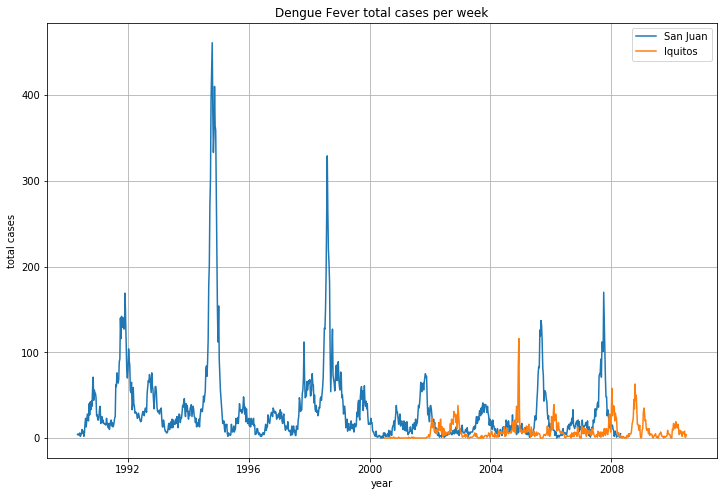

In [8]:
pd_train_sj = df_train_sj.toPandas()
pd_train_iq = df_train_iq.toPandas()

# Total cases per city
plt.figure(figsize=(12, 8))

plt.grid()
plt.title('Dengue Fever total cases per week')

plt.xlabel('year')
plt.ylabel('total cases')
plt.xticks()
plt.yticks()

plt.plot(pd_train_sj['week_start_date'], pd_train_sj['total_cases'], label='San Juan')
plt.plot(pd_train_iq['week_start_date'], pd_train_iq['total_cases'], label='Iquitos')

plt.legend()

plt.show()

### Build new columns

In [9]:
# build a window
w = Window().partitionBy().orderBy(F.col('week_start_date'))

df_train = df_train \
    .withColumn('station_avg_temp_1_c', F.lag('station_avg_temp_c', count=1).over(w)) \
    .withColumn('station_avg_temp_2_c', F.lag('station_avg_temp_c', count=2).over(w)) \
    .withColumn('station_avg_temp_3_c', F.lag('station_avg_temp_c', count=3).over(w)) \
    .withColumn('station_avg_temp_4_c', F.lag('station_avg_temp_c', count=4).over(w)) \
    .withColumn('station_precip_1_mm', F.lag('station_precip_mm', count=1).over(w)) \
    .withColumn('station_precip_2_mm', F.lag('station_precip_mm', count=2).over(w)) \
    .withColumn('station_precip_3_mm', F.lag('station_precip_mm', count=3).over(w)) \
    .withColumn('station_precip_4_mm', F.lag('station_precip_mm', count=4).over(w))

print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))

# we drop the four first rows
df_train = df_train.dropna()
print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))

#df_train.show()

df_train = (1456, 32)
df_train = (1452, 32)


In [10]:
df_train.write.parquet("data/preprocessed")